I am going to learn and apply clustering techniques. I will use [Health News in Twitter](https://archive.ics.uci.edu/ml/datasets/Health+News+in+Twitter) as the text dataset. More concretely I will perform the following tasks.
1. Load the dataset
2. Convert text datapoints to a vector format using **Universal Sentence Encoder**
3. Cluster the vectorized text using **k-Means**.

## Load the dataset
The [Health News in Twitter](https://archive.ics.uci.edu/ml/datasets/Health+News+in+Twitter) data was collected by [Amir Karami](mailto://karami@sc.edu), University of South Carolina in 2015 using Twitter API. This dataset contains health news from more than 15 major health news agencies such as BBC, CNN, and NYT.

In [1]:
import os
import pandas as pd

In [2]:
DATA_ROOT='test'

In [3]:
# directory of `|` separated twitter textfiles
file_list = [os.path.join(DATA_ROOT,file) for file in os.listdir(DATA_ROOT) if file.endswith(".txt")]
df_list = [pd.read_csv(file, header=None, sep='|', usecols=[2]) for file in file_list]
df = pd.concat(df_list)
df.head()

,2
0,Breast cancer risk test devised http://bbc.in/...
1,GP workload harming care - BMA poll http://bbc...
2,Short people's 'heart risk greater' http://bbc...
3,New approach against HIV 'promising' http://bb...
4,Coalition 'undermined NHS' - doctors http://bb...


In [4]:
texts = df[2].tolist()

## Vectorize text data
Clustering algorithms expect n-dimensional data-points as input. So I first need to transform my tweets into n-dimensional vectors. [Word2vec](https://en.wikipedia.org/wiki/Word2vec), [Text2vec](https://github.com/crownpku/text2vec), Facebook's [InferSent](https://github.com/facebookresearch/InferSent), and Google's [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/1) are some of the packages that may be used to get vector embeddings for text data. I am going to use Google's **Universal Sentence Encoder** here.

### Google Universal Sentence Encoder (USE)

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
tf.logging.set_verbosity(tf.logging.ERROR)

#### Utility Wrapper on USE
This class eases the usage of USE

In [6]:
class USEncoder:
    def __init__(self, model_path):
        embed = hub.Module(model_path)
        self.texts = tf.placeholder(dtype=tf.string,shape=[None])
        self.embed_fun = tf.cast(embed(self.texts), tf.float32)
        self.session = tf.Session()
        self.session.run([tf.global_variables_initializer(), tf.tables_initializer()])

    def encode(self, texts):
        return self.session.run(self.embed_fun, feed_dict={self.texts:texts})

#### Create USE Encoder
One small thing to keep in mind is that USE model is around 1GB in size. On first use of `hub.Module(..)` the USE model is downloaded locally from [Tensorflow HUB](https://www.tensorflow.org/hub/). I have setup an environment variable `TFHUB_CACHE_DIR` with the folder path of where I want to locally store the model. `hub.Module(..)` uses this environment variable, and if it finds the cached model, it doesn't download it again.

In [7]:
USE_MODEL_URL = "https://tfhub.dev/google/universal-sentence-encoder/1"
encoder = USEncoder(USE_MODEL_URL)

#### Vector Embeddings

In [8]:
encoded_texts = encoder.encode(texts)

# Clustering
Now I am going to apply k-means alongwith some common clustering techniques to cluster my encoded texts

## k-means
k-means clustering aims to partition `n` observations into `k` clusters in which each observation belongs to the cluster with the nearest mean. One constraint of k-means is that it needs to know the value of `k`. In my dataset I don't know what a reasonable `k` will be. So I am going to try a simple idea. If my data vectors were in 2 dimensional plane then by a visual observation, I may have been able to get a rough idea on the number of clusters to expect. But my USE vectorized data has 512 dimensions. So I am going to use **PCA** (Principal Component Analysis) to reduce the dimensions to 2 and then get a rough idea.

#### PCA

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(encoded_texts)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

#### Visualize

In [11]:
import matplotlib.pyplot as plt

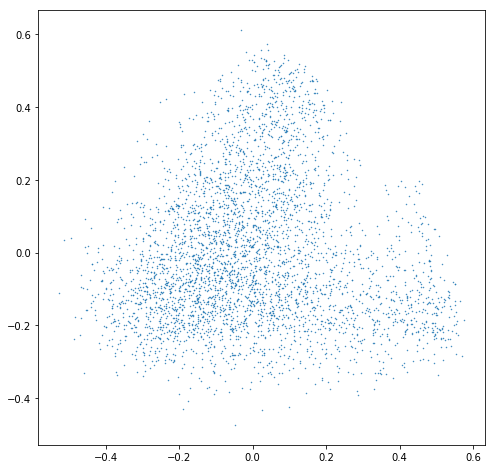

In [12]:
plt.figure(figsize=(8,8))
plt.scatter(principalDf['PC1'], principalDf['PC2'], s=0.2)

Well that didn't much clarify as to what `k` should be. So I am now going to try a bunch of values of `k` and then plot `k` vs. sum of squared errors, to see if an **elbow analysis** gives me some good sense of the number of clusters.

#### k-means

In [13]:
from sklearn.cluster import KMeans

In [14]:
clusters = [KMeans(n_clusters=k).fit(encoded_texts) for k in range(2,40)]

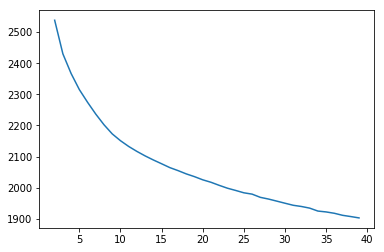

In [15]:
sse = [cluster.inertia_ for cluster in clusters]
plt.plot(list(range(2,40)), sse)

There isn't a clear sense of elbow here. So I am now going to do just one more thing. I am going to use **KMeans labels to colorize the PCA** scatter plots for *k* in range 3 - 8.

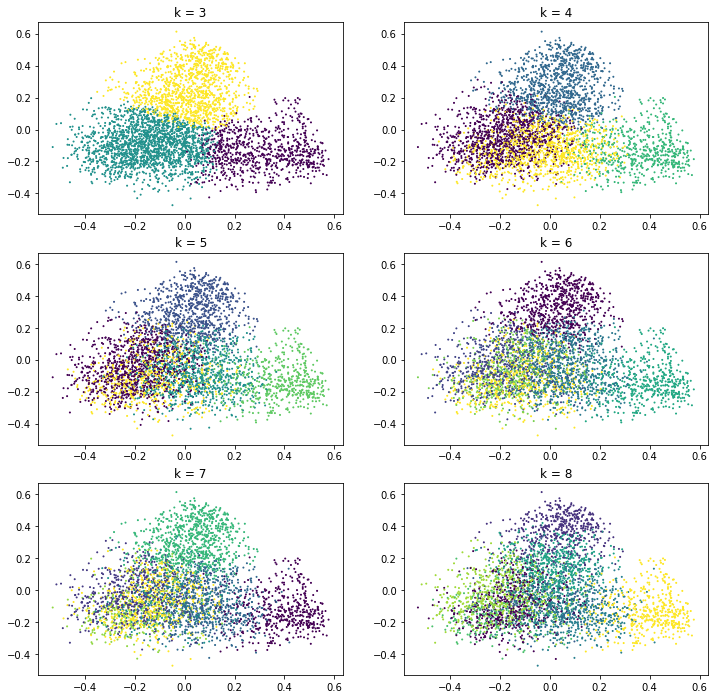

In [16]:
plt.figure(figsize=(12,12))

for i in range(1,7):
    k = 2+i
    k_labels = clusters[k-2].labels_
    plt.subplot(320+i)
    plt.scatter(principalDf['PC1'], principalDf['PC2'], s=1.0, c=k_labels)
    plt.title(f'k = {k}')

#### Check some text samples from each cluster

In [17]:
def groupby_label(labels, texts):
    texts_by_label = {}
    for label, text in zip(labels,texts):
        values = None
        try:
            values = texts_by_label[label]
        except KeyError:
            values = []
            texts_by_label[label] = values        
        values.append(text)
    return texts_by_label

**let me sample some texts in the 8 clusters for k=8**

In [18]:
pd.DataFrame({label:values[:5] 
              for label,values in groupby_label(clusters[8-2].labels_, texts).items()}).T

,0,1,2,3,4
3,Breast cancer risk test devised http://bbc.in/...,Short people's 'heart risk greater' http://bbc...,Personal cancer vaccines 'exciting' http://bbc...,Health highlights http://bbc.in/1EKlFCK,Drug giant 'blocks' eye treatment http://bbc.i...
1,GP workload harming care - BMA poll http://bbc...,Coalition 'undermined NHS' - doctors http://bb...,Review of case against NHS manager http://bbc....,VIDEO: NHS: Labour and Tory key policies http:...,Have GP services got worse? http://bbc.in/1Ci5c22
7,New approach against HIV 'promising' http://bb...,"80,000 'might die' in future outbreak http://b...",Skin cancer 'linked to holiday boom' http://bb...,Unsafe food 'growing global threat' http://bbc...,Uganda circumcision truck fights HIV http://bb...
6,"VIDEO: 'All day is empty, what am I going to d...",VIDEO: 'Overhaul needed' for end-of-life care ...,VIDEO: Skin cancer spike 'from 60s holidays' h...,VIDEO: Welcome to the designer asylum http://b...,VIDEO: Why are we having less sex? http://bbc....
0,Care for dying 'needs overhaul' http://bbc.in/...,A&amp;E waiting hits new worst level http://bb...,Parties row over GP opening hours http://bbc.i...,The Bolivian women who knit parts for hearts h...,First Europe non-beating heart swap http://bbc...
5,Why strenuous runs may not be so bad after all...,Parents rarely spot child obesity http://bbc.i...,Office workers 'too sedentary' http://bbc.in/1...,Fitness linked to lower cancer risk http://bbc...,Approach to obesity 'inexplicable' http://bbc....
4,VIDEO: Health surcharge for non-EU patients ht...,Child heart surgery deaths 'halved' http://bbc...,Ambulance progress 'not fast enough' http://bb...,Care system 'gets biggest shake-up' http://bbc...,More veterans seek mental health aid http://bb...
2,MS drug 'may already be out there' http://bbc....,E-cigarette use 'high among teens' http://bbc....,VIDEO: Could cannabis oil cure cancer? http://...,VIDEO: Toxic smog prompts health warning http:...,New global fund for tobacco control http://bbc...


## Conclusion
This concludes my exploration of clustering some text with k-means. I learnt several things:
* loading and slicing text dataset with pandas
* text vectorization techniques (in particular Google Universal Sentence Encoder)
* Reducing data dimensions with Principal Component Analysis
* Visualizing data with matplotlib
* k-means clustering
* getting a sense of k with elbow analysis
* visualizing clusters with colorized scatter plots
* checking the quality of clusters by sampling texts

I sense that the quality of clusters wasn't quite upto the mark. I guess a bit of **data-cleaning** would help (e.g. removing things like URL links from the tweets).

I am now looking forward to explore more advanced clustering techniques like **Hierarchical Agglomerative Clustering**, and **Affinity Propagation**!